<a href="https://colab.research.google.com/github/ja-yu/AI/blob/main/NeuralNetwork_ch07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/oreilly-japan/deep-learning-from-scratch.git

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 446, done.
remote: Total 446 (delta 0), reused 0 (delta 0), pack-reused 446
Receiving objects: 100% (446/446), 5.52 MiB | 18.16 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [2]:
ls

deep-learning-from-scratch/  sample_data/


In [3]:
cd deep-learning-from-scratch/

/content/deep-learning-from-scratch


In [4]:
ls

ch01/  ch03/  ch05/  ch07/  common/   LICENSE.md*
ch02/  ch04/  ch06/  ch08/  dataset/  README.md


In [5]:
cd ch07/

/content/deep-learning-from-scratch/ch07


In [6]:
ls

apply_filter.py    params.pkl         train_convnet.py
gradient_check.py  simple_convnet.py  visualize_filter.py


In [7]:
cat apply_filter.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学習後の重み
network.load_params("p

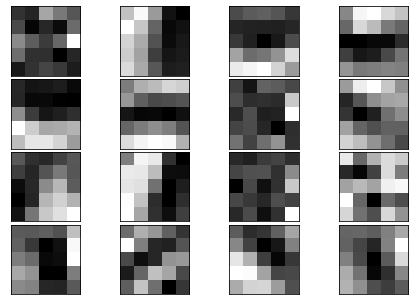

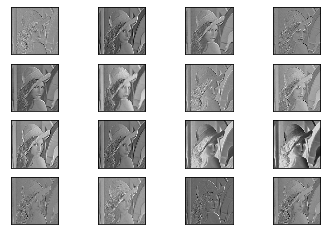

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学習後の重み
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [9]:
cat gradient_check.py

# coding: utf-8
import numpy as np
from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

In [10]:
! python gradient_check.py

W1 4.5116586743772214e-07
b1 2.3072955723882913e-10
W2 9.710974705342374e-12
b2 7.778177545918227e-05
W3 1.0844275819281348e-10
b3 1.7989742508855988e-07


In [11]:
cat params.pkl

UnicodeDecodeError: ignored

In [12]:
cat simple_convnet.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad

In [13]:
! python simple_convnet.py

In [14]:
cat train_convnet.py

# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_para

In [15]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.2980552645054932
=== epoch:1, train acc:0.1, test acc:0.119 ===
train loss:2.2968902463098955
train loss:2.291439615299958
train loss:2.2808194662862
train loss:2.2691142781438756
train loss:2.2696856500459526
train loss:2.25621352151415
train loss:2.2243623515285647
train loss:2.218027688087703
train loss:2.1910102351303125
train loss:2.1316281453973183
train loss:2.1210934280041815
train loss:2.035924515184426
train loss:2.0099606496180726
train loss:1.9446873623729906


KeyboardInterrupt: ignored

In [16]:
cat visualize_filter.py

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

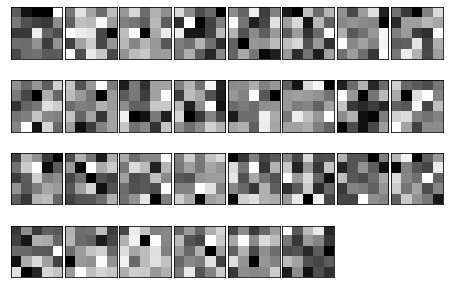

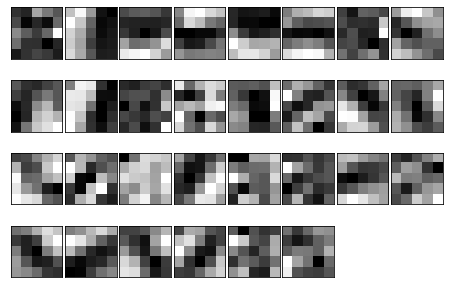

In [17]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])